# **Group Project**

## **GRA 65602 - Strategic Asset Allocation**

This notebook contains the computations and models used to answer the questions

In [203]:
##
#  This cell cleans the environment
##
rm(list = ls())

In [204]:
##
#  This cell installs the packages for the libraries used
#  Uncomment if necessary
##
# install.packages(c("readxl", "ggplot2", "moments", "matlib", "zoo", "latex2exp"))

In [205]:
##
#  This cell loads the libraries and modules needed
#  @library readxl to read excel files
#  @library moments to compute statistics
#  @library zoo to compute correlations in rolling windows
#  @library latex2exp for formatting text in Latex
#  @library showtext to find fonts for plotting
#  @library systemfonts finds fonts for plotting
#  @module portConstruct with various portfolio construction methods
#  @module portUtility with CRRA utility portfolio construction methods
##
library(readxl)
library(moments)
library(zoo)
library(latex2exp)
library(showtext)
library(systemfonts)
source('portConstruct.R')
source("portUtility.R")

In [206]:
##
#  This cell sets Times New Roman as font for the plots
##
tnr_path <- systemfonts::match_fonts("Times New Roman")$path
font_add("Times New Roman", regular = tnr_path)
showtext_auto()
par(family = "Times New Roman")

In [207]:
##
#  This cell loads and transforms the main data set
#  @dataset data.xlsx file containing the data
#  @return dataset expressed in decimals and formated date 
##
data                                      <- read_excel("data.xlsx", sheet = "csv")
data$Date                                 <- as.Date(data$Date, format = "%Y-%m-%d")
names(data)[names(data) == "Date"]        <- "date"
nonPercentage                             <- c("date", "P/D", "P/E")
data[, !(names(data) %in% nonPercentage)] <- data[, !(names(data) %in% nonPercentage)] / 100

In [208]:
##
#  2.1 This cell gets the data used 
##
selectColumns           <- c("date", "us_t1m", "us_infl", "wrld_eq", "wlrd_gbnd")
data7030                <- data[-1, selectColumns]
colnames(data7030)      <- c("date", "rf", "inflation", "equity", "bonds")
head(data7030)

date,rf,inflation,equity,bonds
<date>,<dbl>,<dbl>,<dbl>,<dbl>
1947-01-31,0.0002640758,0.006517691,0.0283385093,0.005332620
1947-02-28,0.0002852513,0.017576318,-0.0003775009,-0.003177945
1947-03-31,0.0002852513,0.000000000,0.0147280967,-0.002681048
1947-04-30,0.0002852187,-0.002272727,0.0078154075,0.002685794
1947-05-31,0.0002852662,0.005922551,-0.0121861152,0.002503421
1947-06-30,0.0002851915,0.006793478,0.0093457944,-0.004443557


[1] " Correlation between equities and bonds, cor(r_equity,r_bonds) = 0.3356"

[1] " Covariance between equities and bonds, cov(r_equity,r_bonds) = 0.00026"

[1] "First(mean) and second(variance) moments of the assets:"

asset,equity,bonds
mean,0.0057,0.0020
sigma,0.0391,0.0200
sigma2,0.0015,0.0004
sharpeRatio,0.1460,0.0977


[1] "-----------------------------------------------------------------------------------------------"

[1] "The infered relative risk aversion of the fund (gamma) is 4.4406"

[1] "-----------------------------------------------------------------------------------------------"

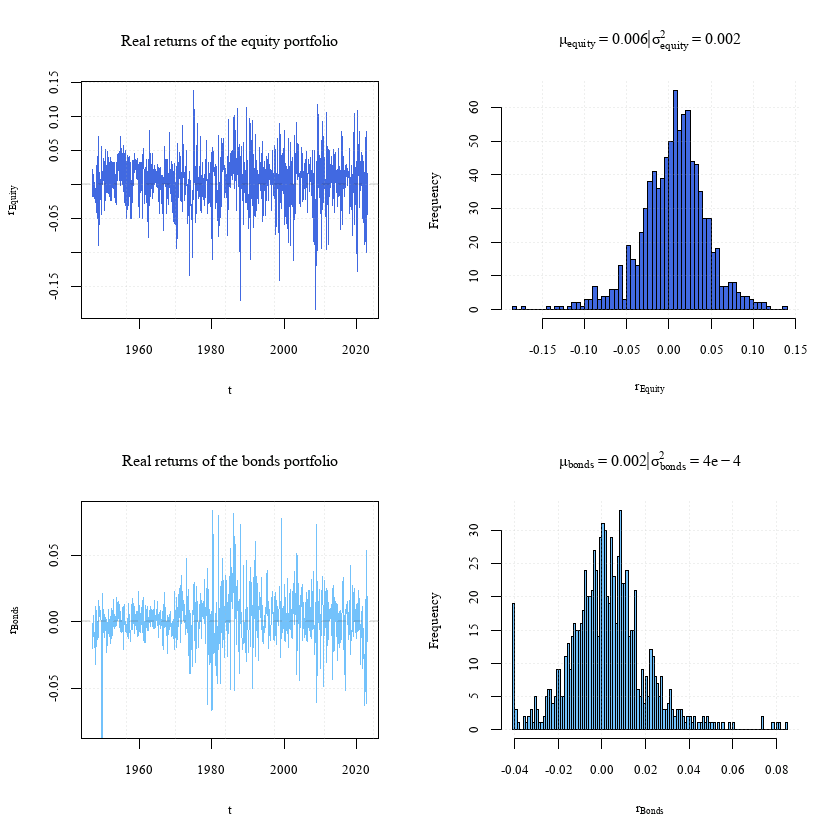

In [209]:
##
#  2.1 This cell infers the relative risk aversion of the fund (gamma)
#  based on the two moments of real returns from equities and bonds
##

# Gets the mean, variance and correlation of equities and bonds
# Uses real returns = (1 + nominal returns) / (1 +  inflation) - 1
rf             <- data7030$rf
rNominalEquity <- data7030$equity
rNominalBonds  <- data7030$bonds 
inflation      <- data7030$inflation
rRealRf        <- (1 + rf)             / (1 + inflation) - 1
rRealEquity    <- (1 + rNominalEquity) / (1 + inflation) - 1
rRealBonds     <- (1 + rNominalBonds)  / (1 + inflation) - 1

# Computes mean, variance, first and second moments of the 2 assets
muRealEquity      <- mean(rRealEquity)
muRealBonds       <- mean(rRealBonds)
varRealEquity     <- var(rRealEquity)
varRealBonds      <- var(rRealBonds)
sdRealEquity      <- sd(rRealEquity)
sdRealBonds       <- sd(rRealBonds)
corEquityBonds    <- cor(rRealEquity, rRealBonds)
covarEquityBonds  <- cov(rRealEquity, rRealBonds)
sharpeRatioEquity <- muRealEquity / sdRealEquity
sharpeRatioBonds  <- muRealBonds  / sdRealBonds

# Print data in a table
meanAssets      <- c(muRealEquity, muRealBonds)
varAssets       <- c(varRealEquity, varRealBonds)
sdAssets        <- c(sdRealEquity, sdRealBonds)
srAssets        <- c(sharpeRatioEquity, sharpeRatioBonds)
moments2Assets  <- data.frame(
                             asset       = c("equity", "bonds"),
                             mean        = round(meanAssets, 4),
                             sigma       = round(sdAssets, 4),
                             sigma2      = round(varAssets, 4),
                             sharpeRatio = round(srAssets, 4)   
                             )
paste(" Correlation between equities and bonds, cor(r_equity,r_bonds) =" ,round(corEquityBonds, 4))
paste(" Covariance between equities and bonds, cov(r_equity,r_bonds) =", round(covarEquityBonds, 5))
paste("First(mean) and second(variance) moments of the assets:")
t(moments2Assets)
paste("-----------------------------------------------------------------------------------------------")

# Compute the inferred risk aversion
# Two fund separation theorem
# gamma = (mu1 - m2) / (w1*(var1 + var2 + 2*cov(1,2)) - (var2 - cov(1,2)))
weightEquity <- 0.70
#gamma        <- ((muRealEquity - muRealBonds) / 
#                (weightEquity * (varRealEquity + varRealBonds + 2*covarEquityBonds) -
#                (varRealBonds - covarEquityBonds))
#                )
gamma <- 4.44060687
paste("The infered relative risk aversion of the fund (gamma) is", round(gamma, 4))
paste("-----------------------------------------------------------------------------------------------")

# Plot the moments of the and distributions of the 2 assets
# Plot the distributions of real returns for the assets
date <- data7030$date
par(mfrow = c(2,2), family = "Times New Roman")
colEquity <- "royalblue"
colBonds  <- "#73C2FB"

# Plots the real returns of equity
t1         <- "Real returns of the equity portfolio"
t2         <- TeX(paste("$\\mu_{equity} = ", round(muRealEquity, 3),
                "| \\sigma^2_{equity} = ", round(varRealEquity, 3),"$"
                  ))
x1         <- TeX("$t$")
y1         <- TeX("$r_{Equity}$")
x2         <- TeX("$r_{Equity}$")
colAbline  <- adjustcolor("black", alpha.f = 0.1)
plot(date, rRealEquity, type = "l", main = t1, xlab = x1, ylab = y1, lwd = 1, col = colEquity)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(rRealEquity, breaks = 100, freq = T, main = t2, xlab = x2, col = colEquity)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Plots the real returns of bonds
t1 <- "Real returns of the bonds portfolio"
t2 <- TeX(paste("$\\mu_{bonds} = ", round(muRealBonds, 3),
                "| \\sigma^2_{bonds} = ", round(varRealBonds, 4),"$"
         ))
x1 <- TeX("$t$")
y1 <- TeX("$r_{Bonds}$")
x2 <- TeX("$r_{Bonds}$")
# Truncates lowest 2% values to get a cleaner plot 
qL      <- quantile(rRealBonds, 0.02)
returns <- rRealBonds*(rRealBonds > qL) + qL*(rRealBonds <= qL)
plot(date, rRealBonds, type = "l", main = t1, xlab = x1, ylab = y1,
     ylim = c(quantile(rRealBonds, 0.001), max(rRealBonds)), lwd = 1, col = colBonds)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(returns, breaks = 100, freq = T, main = t2, xlab = x2, col = colBonds)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

In [210]:
##
#  2.2 This Analyzes improvement in certainty equivalent if investing in rf
##

# Compute the unconstrained optimal portfolio
# Given a relative risk aversion and no risk free rate asset
assets             <- c("equity", "bonds") 
#dataX             <- data7030[, assets]
rExcessEquity      <- rRealEquity - rRealRf
rExcessBonds       <- rRealBonds  - rRealRf
dataX              <- cbind(rExcessEquity, rExcessBonds)
colnames(dataX)    <- c("equity", "bonds")
mu                 <- colMeans(dataX)
sigma              <- cov(dataX)
gamma              <- gamma
wUncNoRf           <- uncMeanVar_ra(mu, sigma, gamma)
muUncNoRf          <- wUncNoRf %*% mu
sdUncNoRf          <- sqrt(wUncNoRf %*% sigma %*% wUncNoRf)
sharpeRatioUncNoRf <- (wUncNoRf %*% mu) / (sqrt(wUncNoRf %*% sigma %*% wUncNoRf))

# Print the portfolio metrics
paste("Unconstrained optimal portofolio, given a relative risk aversion (gamma) and no risk free asset (on real returns)")
paste("mu =", round(muUncNoRf, 4), "sd =", round(sdUncNoRf, 4), "SR=", round(sharpeRatioUncNoRf, 4))
data.frame(round(wUncNoRf, 4))
paste("-----------------------------------------------------------------------------------------------")

# Compute the tangency portfolio introducing risk free asset
rExcessEquity       <- rRealEquity - rRealRf
rExcessBonds        <- rRealBonds  - rRealRf
dataX               <- data.frame(rExcessEquity, rExcessBonds)
colnames(dataX)     <- c("equity", "bonds")
mu                  <- colMeans(dataX)
sigma               <- cov(dataX)
gamma               <- gamma
wTangency           <- uncTangent(mu, sigma)
muTangency          <- wTangency %*% mu
sdTangency          <- sqrt(wTangency %*% sigma %*% wTangency)
sharpeRatioTangency <- (wTangency %*% mu) / (sqrt(wTangency %*% sigma %*% wTangency))

# Print the portfolio metrics
paste("Tangency portolio, introducing risk free asset on excess retuns")
paste("mu =", round(muTangency, 4), "sd =", round(sdTangency, 4), "SR=", round(sharpeRatioTangency, 4))
data.frame(round(wTangency, 4))
paste("-----------------------------------------------------------------------------------------------")

#  Compute the unconstrained mean variance optimization given the risk aversion
#  and risk free asset
optLeverage          <- sharpeRatioTangency / (gamma*sdTangency)
optLeverage          <- as.numeric(optLeverage)
wRiskyUncWithRf      <- optLeverage
wRf                  <- 1 - optLeverage
wUncWithRf           <- c(wRiskyUncWithRf, rf = wRf)
muUncWithRf          <- wRiskyUncWithRf*muTangency + wRf*mean(rRealRf)
sdUncWithRf          <- optLeverage * sdTangency
sharpeRatioUncWithRf <- muUncWithRf / sdUncWithRf

# Print the portfolio metrics
paste("The optimal leverage SR_Tangency/(gamma*sd_Tangency) is", round(optLeverage, 4))
paste("Unconstrained optimal portfolio, introducing risk free asset and given risk aversion")
paste("mu =", round(muUncWithRf, 4), "sd =", round(sdUncWithRf, 4), "SR=", round(sharpeRatioUncWithRf, 4))
data.frame(round(wUncWithRf, 4), row.names = c("risky", "rf"))
paste("-----------------------------------------------------------------------------------------------")

# Compute the certainty equivalent for each of the portfolios built so far
ceNoRf     <- 1 + muUncNoRf   - 0.5*gamma*(sdUncNoRf)^2
ceTangency <- 1 + muTangency  - 0.5*gamma*(sdTangency)^2
ceWithRf   <- 1 + muUncWithRf - 0.5*gamma*(sdUncWithRf)^2

# Print the certainty euivalent for each of the portfolios
paste("The certainty equivalent (CE) for the unconstrained ptf with no rf asset is", round(ceNoRf, 5))
paste("The certainty equivalent (CE) for the tangency ptf is", round(ceTangency, 5))
paste("The certainty equivalent (CE) for the unconstrained ptf with rf asset is", round(ceWithRf, 6))

[1] "Unconstrained optimal portofolio, given a relative risk aversion (gamma) and no risk free asset (on real returns)"

[1] "mu = 0.0043 sd = 0.0297 SR= 0.1456"

,round.wUncNoRf..4.
,<dbl>
equity,0.6871
bonds,0.3129


[1] "-----------------------------------------------------------------------------------------------"

[1] "Tangency portolio, introducing risk free asset on excess retuns"

[1] "mu = 0.0039 sd = 0.0264 SR= 0.1465"

,round.wTangency..4.
,<dbl>
equity,0.5672
bonds,0.4328


[1] "-----------------------------------------------------------------------------------------------"

[1] "The optimal leverage SR_Tangency/(gamma*sd_Tangency) is 1.249"

[1] "Unconstrained optimal portfolio, introducing risk free asset and given risk aversion"

[1] "mu = 0.0048 sd = 0.033 SR= 0.1449"

,round.wUncWithRf..4.
,<dbl>
risky,1.249
rf,-0.249


[1] "-----------------------------------------------------------------------------------------------"

[1] "The certainty equivalent (CE) for the unconstrained ptf with no rf asset is 1.00237"

[1] "The certainty equivalent (CE) for the tangency ptf is 1.00232"

[1] "The certainty equivalent (CE) for the unconstrained ptf with rf asset is 1.002363"

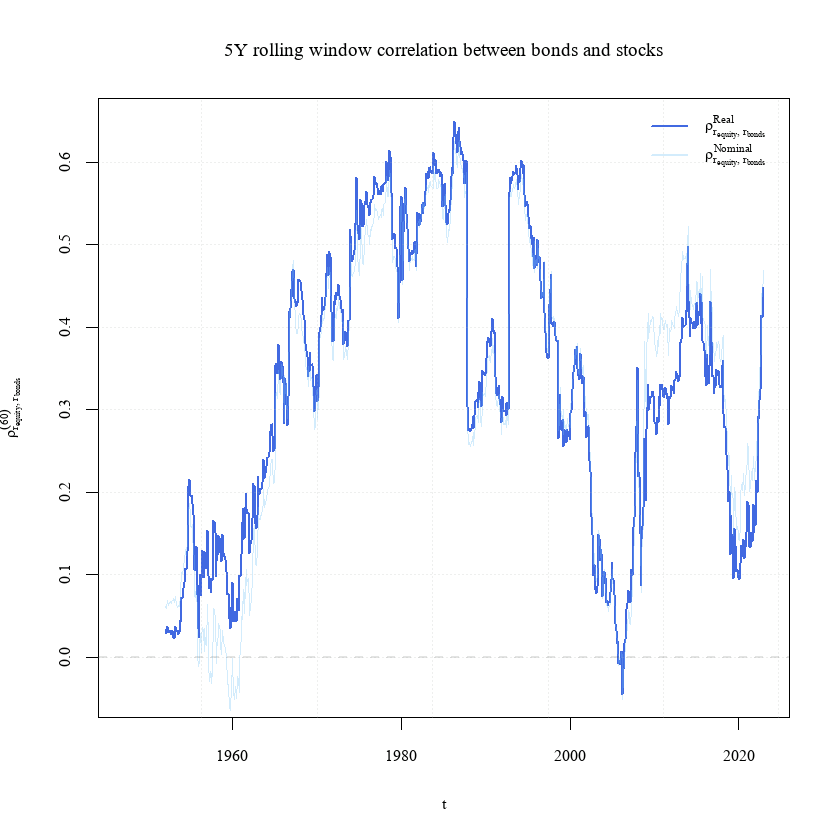

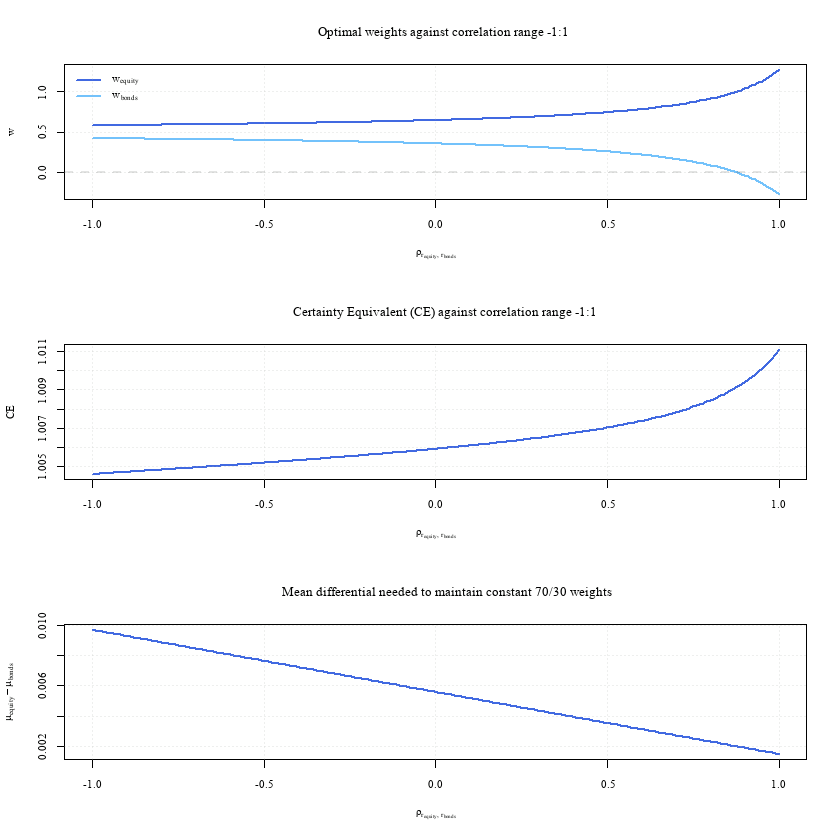

In [211]:
##
#  2.3 Plots 5Y rolling window correlation + finds optimal w and
#  ce over a relevant range of correlations +  meand differencial
#  to maintain constant portfolio weights
##

# Plot 5Y rolling window correlation between bonds and stocks
window                <- 60
xReal                 <- cbind(rRealEquity, rRealBonds)
rollWindowCorrReal    <- rollapply(
                                xReal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
xNominal              <- cbind(rNominalEquity, rNominalBonds)
rollWindowCorrNominal <- rollapply(
                                xNominal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
par(mfrow = c(1,1), family = "Times New Roman")
colReal    <- adjustcolor("royalblue", alpha.f = 1.0)
colNominal <- adjustcolor("#73C2FB", alpha.f = 0.3)
t          <- "5Y rolling window correlation between bonds and stocks"
plot(date, rollWindowCorrReal, type = "l", col = colReal , lwd = 2, main = t,
    xlab = TeX("$t$"), ylab = TeX("$\\rho^{(60)}_{r_{equity},r_{bonds}}$"))
lines(date,rollWindowCorrNominal, col = colNominal)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
legend("topright",
       legend = c(TeX("$\\rho^{Real}_{r_{equity},r_{bonds}}$"), 
       TeX("$\\rho^{Nominal}_{r_{equity},r_{bonds}}$")),
       col = c(colReal, colNominal),
       lwd = 2,
       bg = "white",
       bty = "n")

# Analyzes the optimal portfolio and CE for a relevant range of correlations
# Assume all moments remain constant, uses two fund separation theorem
gamma  <- gamma
mu1    <- muRealEquity
mu2    <- muRealBonds
var1   <- varRealEquity
var2   <- varRealBonds
sigma1 <- sdRealEquity
sigma2 <- sdRealBonds
cor    <- seq(-1.0, 1.0, length.out = 200)

# Solves for the weights and CE
# w1 = {1/gamma * (mu1-mu2) + (s2^2-cov(1,2))} / {s1^2 + s2^2 - 2*cov(1,2)}
# cov(1,2) = corr(1,2)*s1*s2
w1  <- rep(0, length(cor))
w2  <- rep(0, length(cor))
mu  <- rep(0, length(cor))
var <- rep(0, length(cor))
sd  <- rep(0, length(cor))
ce  <- rep(0, length(cor))

for (i in 1:length(cor)) {
  w1[i]  <- (((1/gamma)*(mu1-mu2) + var2 - cor[i]*sigma1*sigma2) /
             (var1 + var2 - 2*cor[i]*sigma1*sigma2)
            )
  w2[i]  <- 1 - w1[i]
  mu[i]  <- w1[i]*mu1 + w2[i]*mu2
  var[i] <- w1[i]^2*var1 + 2*w1[i]*w2[i]*cor[i]*sigma1*sigma2 + w2[i]^2*var2
  sd[i]  <- sqrt(var[i])
  ce[i]  <- 1+mu[i] + 0.5*gamma*sd[i]^2
}

# Plot weights against correlation
par(mfrow = c(3,1))
yMin <- min(w1, w2)
yMax <- max(w1,w2)
t    <- TeX("Optimal weights against correlation range -1:1")
plot(cor, w1, type = "l", col = "royalblue", ylim = c(yMin, yMax), lwd = 2,
     main = t, xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$w$"))
lines(cor, w2, col = "#73C2FB", lwd = 2)
legend("topleft",
       legend = c(TeX("$w_{equity}$"), 
       TeX("$w_{bonds}$")),
       col = c("royalblue", "#73C2FB"),
       lwd = 2,
       bg = "white",
       bty = "n")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

# Plot certainty equivalent against correlations
t <- TeX("Certainty Equivalent (CE) against correlation range -1:1")
plot(cor, ce, type = "l", col = "royalblue", lwd = 2, main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$CE$"))
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# How mean differential should change to maintain constant ptf weights
# w1 = 0.70
# mu1 - mu2 = gamma*w1*(s1^2+s2^2-2*cov(1,2) - s2^2 + cov(1,2)
w1          <- 0.70
gamma       <- gamma
mu1         <- mu1
mu2         <- mu2
var1        <- var1
var2        <- var2
sigma1      <- sigma1
sigma2      <- sigma2
cor         <- cor
mu1Minusmu2 <- rep(0, length(cor))
for (i in 1:length(cor)){
  mu1Minusmu2[i] <- (gamma*w1*(var1 + var2 - 2*cor[i]*sigma1*sigma2)
                     - var2 + cor[i]*sigma1*sigma2
                    )
}

# Plot expected return differential to maintain constant weights
t <- TeX("Mean differential needed to maintain constant 70/30 weights")
plot(cor, mu1Minusmu2, type = "l", lwd = 2, col = "royalblue", main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$\\mu_{equity}-\\mu_{bonds}$")
    )
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
par(mfrow = c(1,1))

In [212]:
##
#  2.4 Computes optimal weights under CRRA utility lognormal + historical
##

# Compute optimal weights under CRRA utility and lognormal returns
dataX              <- data.frame(rExcessEquity, rExcessBonds)
gamma              <- gamma
mu                 <- colMeans(dataX)
sigma              <- cov(dataX)
wCrraLog           <- portCRRA(data = dataX, model = "lognorm", gamma = gamma)
muCrraLog          <- as.numeric(wCrraLog %*% mu)
sdCrraLog          <- sqrt(as.numeric(wCrraLog %*% sigma %*% wCrraLog))
sharpeRatioCrraLog <- (wCrraLog %*% mu) / (sqrt(wCrraLog %*% sigma %*% wCrraLog))
ptsGaussHermite    <- gauss.hermite(20)
pGaussHermite      <- ptsGaussHermite[, 2]
rExcessPortfolio   <- as.numeric(muCrraLog + sdCrraLog * ptsGaussHermite[, 1])
rPortfolio         <- 1 + rExcessPortfolio
ceCrraLog          <- (sum(pGaussHermite*rPortfolio^(1-gamma)))^(1/(1-gamma))

paste("Optimal weights under CRRA utility and lognormal returns")
paste("mu =", round(muCrraLog, 4), "sd =", round(sdCrraLog, 4), "SR =", round(sharpeRatioCrraLog, 4), "CE =", round(ceCrraLog, 4))
data.frame(round(wCrraLog,4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Compare with mean variance ptf given a riks aversion and rf (excess returns)
dataX                   <- dataX
gamma                   <- gamma
mu                      <- colMeans(dataX)
sigma                   <- cov(dataX)
wMeanVariance           <- uncMeanVar_ra(mu, sigma, gamma)
muMeanVariance          <- wMeanVariance %*% mu
sdMeanVariance          <- sqrt(wMeanVariance %*% sigma %*% wMeanVariance)
sharpeRatioMeanVariance <- (wMeanVariance %*% mu) / (sqrt(wMeanVariance %*% sigma %*% wMeanVariance))
ceMeanVariance          <- 1 + muMeanVariance - 0.5*gamma*sdMeanVariance^2

paste("Optimal weights under mean variance ptf given a risk aversion and rf (excess returns)")
paste("mu =", round(muMeanVariance, 4), "sd =", round(sdMeanVariance, 4), "SR =", round(sharpeRatioMeanVariance, 4), "CE =", round(ceMeanVariance, 4))
data.frame(round(wMeanVariance, 4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Add historical portfolio excess retuns
dataX                     <- dataX
gamma                     <- gamma
mu                        <- colMeans(dataX)
sigma                     <- cov(dataX)   
wCrraHistorical           <- portCRRA(data = dataX, model = "hist", gamma = gamma)
muCrraHistorical          <- as.numeric(wCrraHistorical %*% mu)
sdCrraHistorical          <- sqrt(as.numeric(wCrraHistorical %*% sigma %*% wCrraHistorical))
sharpeRatioCrraHistorical <- (wCrraHistorical %*% mu) / (sqrt(wCrraHistorical %*% sigma %*% wCrraHistorical))
rExcessPortfolio          <- as.numeric(as.matrix(dataX) %*% wCrraHistorical)
ceCrraHistorical          <- (mean((1+rExcessPortfolio)^(1-gamma)))^(1/(1-gamma))

paste("Optimal weights under CRRA utility and historical simulation")
paste("mu =", round(muCrraHistorical, 4), "sd =", round(sdCrraHistorical, 4), "SR =", round(sharpeRatioCrraHistorical, 4), "CE =", round(ceCrraHistorical, 4))
data.frame(round(wCrraHistorical, 5), row.names = c("equity", "bonds"))

[1] "Optimal weights under CRRA utility and lognormal returns"

[1] "mu = 0.0043 sd = 0.0293 SR = 0.1457 CE = 1.0024"

,round.wCrraLog..4.
,<dbl>
equity,0.6758
bonds,0.3240


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under mean variance ptf given a risk aversion and rf (excess returns)"

[1] "mu = 0.0043 sd = 0.0297 SR = 0.1456 CE = 1.0024"

,round.wMeanVariance..4.
,<dbl>
equity,0.6871
bonds,0.3129


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under CRRA utility and historical simulation"

[1] "mu = 0.0042 sd = 0.0288 SR = 0.146 CE = 1.0023"

,round.wCrraHistorical..5.
,<dbl>
equity,0.65751
bonds,0.34228


[1] "Optimal weights under MV portfolio without the rf asset"

[1] "mu = 0.0044 sd = 0.0294 SR = 0.1509 CE = 1.0025"

,round.wMeanVarianceNoRf..4.
,<dbl>
developed,-0.2180
emerging,0.1561
equity,0.7604
bonds,0.5497
bondsExUS,-0.2482


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under the tangenct portfolio withe the rf asset"

[1] "mu = 0.0037 sd = 0.0241 SR = 0.1533 CE = 1.00241"

,round.wTangencyRf..4.
,<dbl>
developed,-0.1755
emerging,0.1245
equity,0.5718
bonds,0.9275
bondsExUS,-0.4483


[1] "-----------------------------------------------------------------------------------------------"

,developed,emerging,equity,bonds,bondsExUS,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wBenchmark,0.000,0.0000,0.7000,0.3000,0.0000,0.0044,0.0300,0.1454,1.0024
wMeanVarianceNoRf,-0.218,0.1561,0.7604,0.5497,-0.2482,0.0044,0.0294,0.1509,1.0025


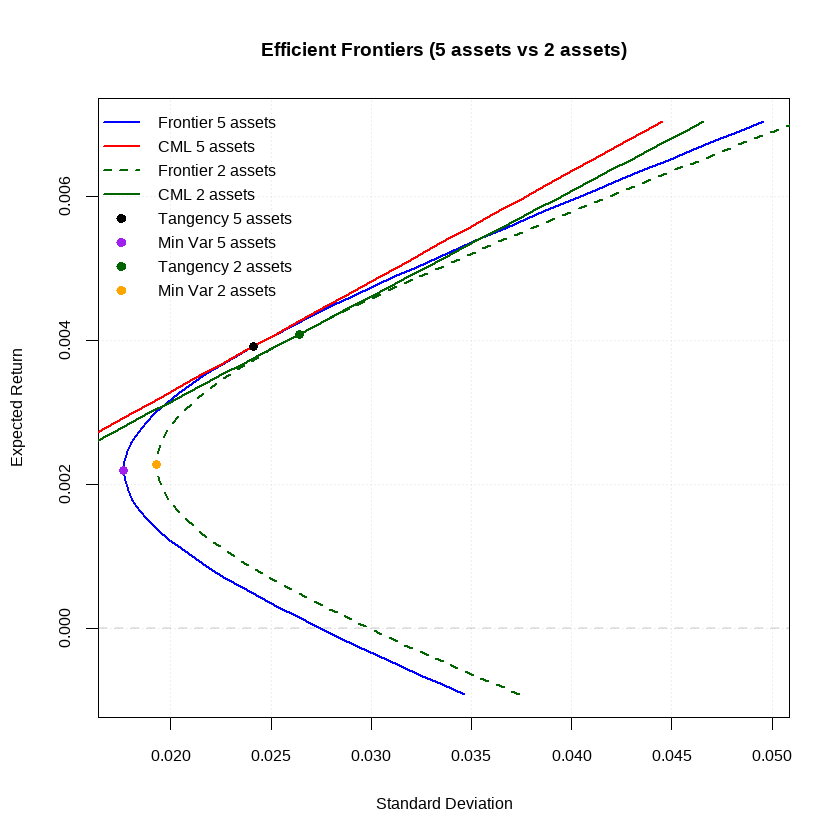

In [213]:
##
#  2.5 Mean variance analysis incorporating more than two asset classes
##

# Gets the selected indices to be incorporated
# dvlp_eq	 GFD Indices Developed World x/North America Return Index
# emrg_eq	 GFD Indices Emerging Markets Return Index
# wrld_eq	 GFD Indices All World Return Index
# wrld_gbnd	 GFD Indices World Government Bond GDP-weighted Return Index
# wrldx_gbnd GFD Indices World x/USA Countries Government Bond GDP-weighted Return Index
assets          <- c("dvlp_eq", "emrg_eq", "wrld_eq", "wlrd_gbnd", "wrldx_gbnd")
dataX           <- data[-1, assets]
colnames(dataX) <- c("developed", "emerging", "equity", "bonds", "bondsExUS")
rRealRf         <- rRealRf
inflation       <- inflation
dataReal        <- (1 + dataX) / (1 + inflation) - 1 
dataExcess      <- dataReal - rRealRf


# Compute MV portfolio without the rf asset,
mu                          <- colMeans(dataExcess)
sigma                       <- cov(dataExcess)
gamma                       <- gamma
wMeanVarianceNoRf           <- uncMeanVar_ra(mu, sigma, gamma)
muMeanVarianceNoRf          <- as.numeric(wMeanVarianceNoRf %*% mu)
sdMeanVarianceNoRf          <- sqrt(as.numeric(wMeanVarianceNoRf %*% sigma %*% wMeanVarianceNoRf))
sharpeRatioMeanVarianceNoRf <- (wMeanVarianceNoRf %*% mu) / (sqrt(wMeanVarianceNoRf %*% sigma %*% wMeanVarianceNoRf))
ceMeanVarianceNoRf          <- 1 + muMeanVarianceNoRf - 0.5*gamma*sdMeanVarianceNoRf^2

paste("Optimal weights under MV portfolio without the rf asset")
paste("mu =", round(muMeanVarianceNoRf, 4), "sd =", round(sdMeanVarianceNoRf, 4), "SR =", round(sharpeRatioMeanVarianceNoRf, 4), "CE =", round(ceMeanVarianceNoRf, 4))
data.frame(round(wMeanVarianceNoRf, 4), row.names = c("developed", "emerging", "equity", "bonds", "bondsExUS"))
paste("-----------------------------------------------------------------------------------------------")

# Compute the tangenct portfolio withe the rf asset
mu                          <- colMeans(dataExcess)
sigma                       <- cov(dataExcess)
gamma                       <- gamma
wTangencyRf                 <- uncTangent(mu, sigma)
muTangencyRf                <- as.numeric(wTangencyRf %*% mu)
sdTangencyRf                <- sqrt(as.numeric(wTangencyRf %*% sigma %*% wTangencyRf))
sharpeRatioTangencyRf       <- (wTangencyRf %*% mu) / (sqrt(wTangencyRf %*% sigma %*% wTangencyRf))
ceTangencyRf                <- 1 + muTangencyRf - 0.5*gamma*sdTangencyRf^2

paste("Optimal weights under the tangenct portfolio withe the rf asset")
paste("mu =", round(muTangencyRf, 4), "sd =", round(sdTangencyRf, 4), "SR =", round(sharpeRatioTangencyRf, 4), "CE =", round(ceTangencyRf, 5))
data.frame(round(wTangencyRf, 4), row.names = c("developed", "emerging", "equity", "bonds", "bondsExUS"))
paste("-----------------------------------------------------------------------------------------------")

# Plot the efficient frontier without rf
mu               <- colMeans(dataExcess)
sigma            <- cov(dataExcess)
rf               <- mean(rRealRf)

# Start with the 5 assets ptf
wTangencyRf      <- wTangencyRf
muTangencyRf     <- muTangencyRf
sdTangencyRf     <- sdTangencyRf

wMinVariance     <- portMinVar(sigma)
muMinVariance    <- as.numeric(t(wMinVariance) %*% mu)
sdMinVariance    <- sqrt(as.numeric(t(wMinVariance) %*% sigma %*% wMinVariance))

rangeMu <- seq(from = -0.2 * max(mu),
               to   =  1.2 * max(mu),
               length.out = 60)

M <- matrix(NA, nrow = length(rangeMu), ncol = 4)

i <- 1
for(muTarget in rangeMu){

    wPtf         <- uncMeanVar_mu(mu, sigma, muTarget)
    muNoRf       <- rf + as.numeric(t(wPtf) %*% mu)
    sdNoRf       <- sqrt(as.numeric(t(wPtf) %*% sigma %*% wPtf))

    leverage     <- muTarget / muTangencyRf
    muRfLine     <- rf + muTarget
    sdRfLine     <- leverage * sdTangencyRf

    M[i, ]       <- c(muNoRf, sdNoRf, muRfLine, sdRfLine)
    i <- i + 1
}

# Continue with equity and bonds ptf
dataTwoAssets  <- dataExcess[, c("equity", "bonds")]
muTwoAssets    <- colMeans(dataTwoAssets)
sigmaTwoAssets <- cov(dataTwoAssets)

wTangencyTwo   <- uncTangent(muTwoAssets, sigmaTwoAssets)
muTangencyTwo  <- as.numeric(t(wTangencyTwo) %*% muTwoAssets)
sdTangencyTwo  <- sqrt(as.numeric(t(wTangencyTwo) %*% sigmaTwoAssets %*% wTangencyTwo))

wMinVarTwo     <- portMinVar(sigmaTwoAssets)
muMinVarTwo    <- as.numeric(t(wMinVarTwo) %*% muTwoAssets)
sdMinVarTwo    <- sqrt(as.numeric(t(wMinVarTwo) %*% sigmaTwoAssets %*% wMinVarTwo))

TTwo <- matrix(NA, nrow = length(rangeMu), ncol = 4)

i <- 1
for(muTarget in rangeMu){

    wTwo        <- uncMeanVar_mu(muTwoAssets, sigmaTwoAssets, muTarget)
    muNoRfTwo   <- rf + as.numeric(t(wTwo) %*% muTwoAssets)
    sdNoRfTwo   <- sqrt(as.numeric(t(wTwo) %*% sigmaTwoAssets %*% wTwo))

    leverageTwo <- muTarget / muTangencyTwo
    muRfTwo     <- rf + muTarget
    sdRfTwo     <- leverageTwo * sdTangencyTwo

    TTwo[i, ]   <- c(muNoRfTwo, sdNoRfTwo, muRfTwo, sdRfTwo)
    i <- i + 1
}

# Plot
plot(M[,2], M[,1], type="l", lwd=2, col="blue",
     xlab="Standard Deviation", ylab="Expected Return",
     main="Efficient Frontiers (5 assets vs 2 assets)")

lines(M[,4], M[,3], col="red", lwd=2)
lines(TTwo[,2], TTwo[,1], col="darkgreen", lwd=2, lty=2)
lines(TTwo[,4], TTwo[,3], col="darkgreen", lwd=2, lty=1)

points(sdTangencyRf,  rf + muTangencyRf,  pch=19, col="black")
points(sdMinVariance, rf + muMinVariance, pch=19, col="purple")
points(sdTangencyTwo, rf + muTangencyTwo, pch=19, col="darkgreen")
points(sdMinVarTwo,   rf + muMinVarTwo,   pch=19, col="orange")

grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

legend("topleft",
       legend=c("Frontier 5 assets", "CML 5 assets",
                "Frontier 2 assets", "CML 2 assets",
                "Tangency 5 assets", "Min Var 5 assets",
                "Tangency 2 assets", "Min Var 2 assets"),
       col=c("blue","red","darkgreen","darkgreen","black","purple","darkgreen","orange"),
       lty=c(1,1,2,1,NA,NA,NA,NA),
       pch=c(NA,NA,NA,NA,19,19,19,19),
       lwd=2, bty = "n")

# Compare against benchmark strategy
wBenchmark           <- c(0.0, 0.0, 0.70, 0.30, 0)   
mu                   <- colMeans(dataExcess)
sigma                <- cov(dataExcess)
muBenchmark          <- as.numeric(wBenchmark %*% mu)
sdBenchmark          <- sqrt(as.numeric(t(wBenchmark) %*% sigma %*% wBenchmark))
sharpeRatioBenchmark <- muBenchmark / sdBenchmark
ceBenchmark          <- 1 + muBenchmark - 0.5 * gamma * sdBenchmark^2


t <- data.frame(rbind(wBenchmark, wMeanVarianceNoRf), mean = c(muBenchmark, muMeanVarianceNoRf),
               sd = c(sdBenchmark, sdMeanVarianceNoRf), SR = c(sharpeRatioBenchmark, sharpeRatioMeanVarianceNoRf),
               ce = c(ceBenchmark, ceMeanVarianceNoRf)
               )
round(t, 4)


In [214]:
##
#  3.0 Add NTW into account (i) no leverage or ptf constraints
#  and (ii) restricted of leverage or short-selling
##

# Gets the unconstrained ptf based on the benchmark strategy
wEquity           <- 0.70
wBonds            <- 0.30
gamma             <- gamma
dataX             <- data.frame(cbind(rExcessEquity, rExcessBonds))
colnames(dataX)   <- c("equity", "bonds") 
rNtw              <- wEquity*dataX$equity + wBonds*dataX$bonds # rNTW- oil
mu                <- colMeans(dataX)
sigma             <- cov(dataX)
sigmaN            <- cov(rNtw, dataX)
betaN             <- inv(sigma) %*% as.numeric(sigmaN)
wBenchmark        <- c(wEquity, wBonds)
y                 <- 0.25/1
xMyopic           <- wBenchmark / (1 - y) 
xHedge            <- (y / (1 - y)) * betaN
xUnc              <- xMyopic - xHedge
xUnc              <- as.numeric(xUnc)      # ensure numeric vector
xUnc              <- xUnc / sum(xUnc) 
muUncNtw          <- as.numeric(xUnc %*% mu)
sdUncNtw          <- sqrt(as.numeric(t(xUnc) %*% sigma %*% xUnc))
sharpeRatioUncNtw <- muUncNtw / sdUncNtw
rPortfolio        <- as.matrix(dataX) %*% xUnc
rTotal            <- y * rNtw + (1 - y) * rPortfolio
ceUncNTW          <- 1 + mean(rTotal) - 0.5 * gamma * sd(rTotal)^2

paste("Optimal weights under unconstrained ptf based on the benchmark strategy and NTW")
paste("mu =", round(muUncNtw, 4), "sd =", round(sdUncNtw, 4), "SR =", round(sharpeRatioUncNtw, 4), "CE =", round(ceUncNTW, 4))
data.frame(round(xUnc, 4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Computes the constrained ptf




[1] "Optimal weights under unconstrained ptf based on the benchmark strategy and NTW"

[1] "mu = 0.0044 sd = 0.03 SR = 0.1454 CE = 1.0024"

,round.xUnc..4.
,<dbl>
equity,0.7
bonds,0.3


[1] "-----------------------------------------------------------------------------------------------"